## The Implementation of Pegasos Algorithm for Support Vector Machines

The below functions were written for the implementation of Support Vector Machines to classify positive and negative movie reviews. The algorithm is called Pegasos, which stands for Primal Estimated sub-GrAdient SOlver for SVM. The aim here is the effective optimization of the classification algorithm by Stochastic Subgradient Descent method. 

- The dataset is a set of movie reviews (plain text) that was labeled as either positive or negative. 
- The first functions below load those data, remove symbols from it, and shuffle it to get a random sequence of reviews.
- Then the data is split into two (3:1) as training data and test data. 
- The data is represented as __sparse dictionaries of word counts__ because the whole dictionary (with all the words used in the reviews dataset) consists of hundreds of thousands of words, and we don't want to make computations with that long list at every step. So I wrote a function below to get the sparse representations of each review with respect to the corpus dictionary. For example the phrase 'Picasso is here' is represented as a dictionary: {'Picasso':1, 'is': 1, 'here':1}.

- __On the Pegasos Implemetation__: The 'theta' vector being updated is our prediction vector. It is multiplied by the sparse representation of each review in order to obtain a score for that review. We initialize theta as a zero vector, then as we get 'false results', the algorithm updates the theta vector in the direction that provides the greatest decrease in loss in terms of our loss function (stochastic gradient descent). Finally the loss converges, and the theta vector is optimized. The function returns the theta history, and loss history. (Brief Warning: You shouldn't print theta vector at each step - that's why it only appears at the end of the algorithm, since it's very large, it will crash any regular computer with regular memory).  

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import os
import numpy as np
import pickle
import random

def folder_list(path,label):
    filelist = os.listdir(path)[2:]
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review

def read_data(file):

    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/\&|<>=~" '
    words = list(map(lambda Element: \
                     ((bytes(Element.encode('utf-8'))).\
                      translate(None, b'${}()[].,:;+-*/\&|<>=~"')).\
                     decode("utf-8") , lines))
    words = list(filter(None, words))
    return list(words)

In [20]:
def shuffle_data():
    ## you can change the file path to your local path
    pos_path = '/Users/derin/Desktop/pegasos_asena/data/pos/'
    neg_path = '/Users/derin/Desktop/pegasos_asena/data/neg/'
	
    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)
	
    review = pos_review + neg_review
    random.shuffle(review)
    return review

shuffled_reviews = shuffle_data()

In [21]:
from sklearn.model_selection import train_test_split

X = [list(r[:-1]) for r in shuffled_reviews]
y = [r[-1] for r in shuffled_reviews]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25)

print ('X_train.length = ' + str(len(X_train)))
print ('X_val.length = ' + str(len(X_val)))
print ('y_train.length = ' + str(len((y_train))))
print ('y_val.length = ' + str(len(y_val)))

X_train.length = 0
X_val.length = 0
y_train.length = 0
y_val.length = 0


In [5]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

In [6]:
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

In [7]:
from collections import Counter
def count_sparse(file):
    ### sparse vector of the single file
    dict_file = Counter(file)
    return dict_file
# count_sparse(X_train[1])

In [8]:
def sparse_dict(file_list):
    '''file_list = data, for instance X_train
    all the content in corpus, concatenated in A LIST
    Create a central dictionary for every feature in
    the corpus'''
    concat_file = sum([f for f in file_list], [])
    ### the dictionary (just counts)
    dict_concat = Counter(concat_file)
    return dict_concat

corpus_dict = sparse_dict(X_train)      

In [9]:
def sparse_rep(file): 
    dict_file = Counter(file)
    vector_rep = [dict_file.get(key, 0) for key in corpus_dict.keys()]
    sparse_rep = {}
    for i in range(len(vector_rep)):
        if vector_rep[i] != 0:
            sparse_rep[i] = vector_rep[i]
        else:
            None
    return sparse_rep

In [10]:
def vector_rep(file): 
    vector_rep = np.zeros(len(corpus_dict.keys()))
    sparse_dict = sparse_rep(file)
    for key in sparse_dict.keys():
        vector_rep[key] = sparse_dict[key]
    return vector_rep

In [11]:
# theta = sparse_rep([''])
def compute_regularized_hinge_loss(X, i, y, theta, lambda_reg):
    '''Designed to be implemented on individual instances.'''
     
    loss = (lambda_reg/2)*(dotProduct(theta, theta)) + \
            (np.amax([0, 1-(y[i]*(dotProduct(theta, sparse_rep(X[i]))))])) 
    return loss

# compute_regularized_hinge_loss(X_train, 1, y_train, theta, 0.01)

In [12]:
def compute_zero_one_loss(X, index_begin, index_end, y, theta):
    '''Compute the percentage 0-1 loss for a series of X,y pairs,
    single-index loss: index_begin = i, index_end = i + 1'''
    '''multiple-index loss: index_begin = i, index_end = i + n '''
    ## Create a list of sparse vectors (dicts)
    sparse_list = [sparse_rep(x) for x in X[index_begin:index_end]]
    signs = [np.sign(dotProduct(theta, s)) for s in sparse_list]
    loss_list = [np.amax([0, -y[i]*signs[i]]) for i in range(len(signs))]
    print (loss_list)
    percentage_loss = np.sum(loss_list)/len(loss_list)
    return percentage_loss

# compute_zero_one_loss(X_train, 30, 300, y_train, theta_1)

## Pegasos Implementation

In [13]:
def pegasos(X, y, max_iter=1000, lambda_reg=None):
    num_instances = len(X)
    loss_hist = []
    theta_hist = {}
    theta = sparse_rep(['']) 
    theta_hist[0] = theta
    t = 0
    for epoch in range(1, max_iter):
        theta_hist[epoch] = theta
        np.random.shuffle(X)
        for i in range(1, num_instances):
            t = t + 1
            update_dict = {}
            xs = sparse_rep(X[i])
            learning_rate = 1/(lambda_reg*t) 
            update_dict = {x: xs[x]*y[i] for x in xs} 

            increment(theta, (-(learning_rate*lambda_reg)), theta)
            increment (theta, learning_rate*int((y[i]*dotProduct(theta, xs))<1), \
                       update_dict)
            loss_hist.append\
            (compute_regularized_hinge_loss(X, i, y, theta, lambda_reg))
            
    return theta_hist, loss_hist

In [17]:
pegasos(X_train[:100], y_train[:100], lambda_reg=1, max_iter=10)

({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}, [])

In [15]:
loss_hist = pegasos(X_train, y_train, lambda_reg=0.1, max_iter=10)

ValueError: setting an array element with a sequence.

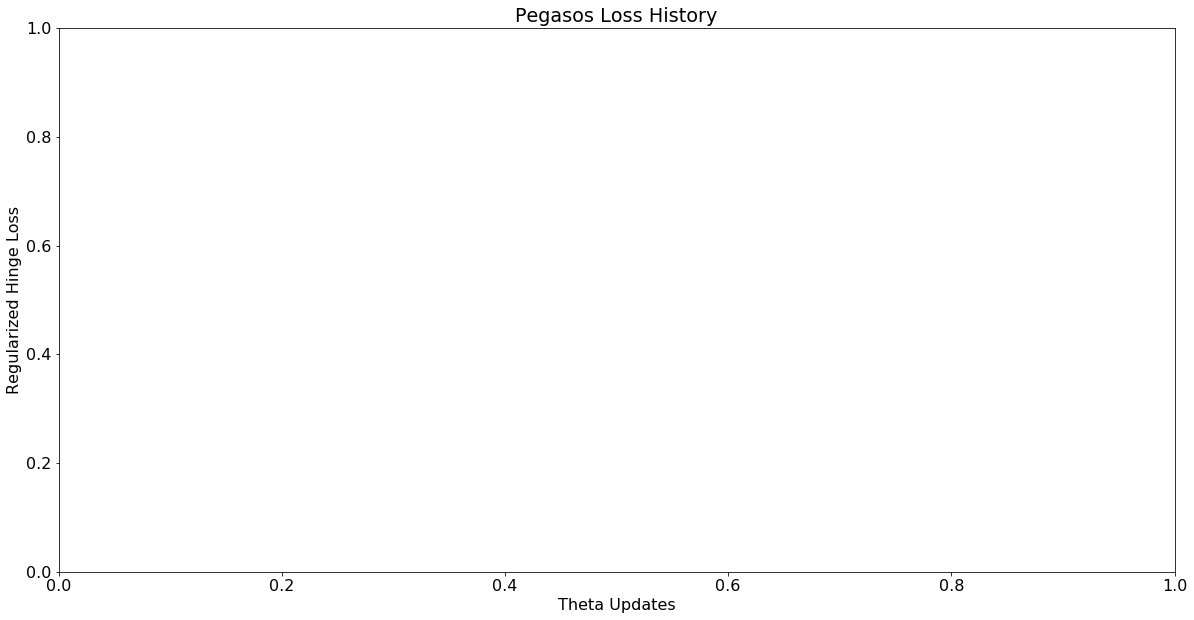

In [16]:
plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = 16
plt.title('Pegasos Loss History')
plt.xlabel('Theta Updates')
plt.ylabel('Regularized Hinge Loss')
plt.plot(loss_hist, linewidth=2, alpha=0.7, color='crimson')

In [146]:
def pegasos_vector(X, y, max_iter=1000, lambda_reg=None):
    s = 1
    W = vector_rep(sparse_rep(['']))
    num_instances = len(X)
    loss_hist = []
    theta_hist = {}
    t = 2
    for epoch in range(1, max_iter):
        np.random.shuffle(X)
        for i in range(1, num_instances):
            learning_rate = 1/(lambda_reg*t)  
            t = t + 1
            s = (1-learning_rate*lambda_reg)*s
            theta = s*W
            
            W = W + (1/s)*\
            learning_rate*(y[i]*np.array(vector_rep(X[i])))*\
            int(y[i]*(np.dot(np.transpose(vector_rep(X[i])), theta)<1))
            
            loss_hist.append\
            ((lambda_reg/2)*np.dot(np.transpose(theta), theta) \
             + np.amax([0, 1-(y[i]*(np.dot(np.transpose(vector_rep(X[i])), theta)))]))
#         print (loss_hist)
        theta_hist[epoch] = theta
    return theta_hist, loss_hist

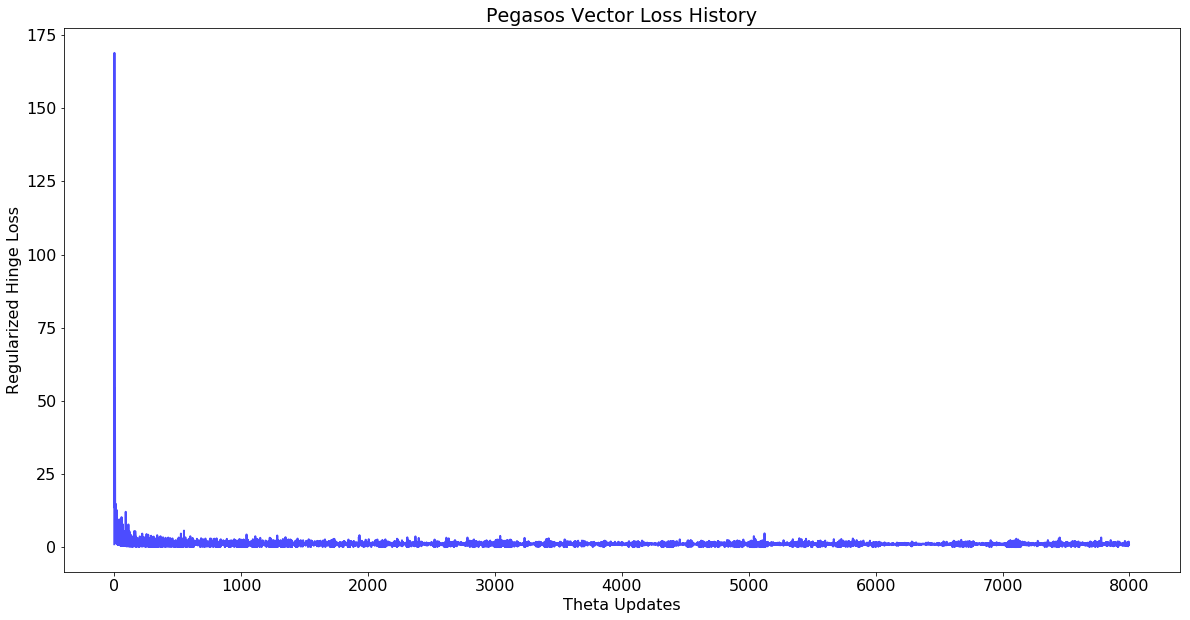

In [21]:
loss_hist_pv = pegasos_vector(X, y, max_iter=5, lambda_reg=10)[1]
plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = 16
plt.title('Pegasos Vector Loss History')
plt.xlabel('Theta Updates')
plt.ylabel('Regularized Hinge Loss')
plt.plot(loss_hist_pv, linewidth=2, alpha=0.7, color='blue')

In [ ]:
### Checking which one of the algorithms is running faster

In [33]:
import time
import timeit
print ('pegasos time')
%time pegasos(X_train, y_train, lambda_reg=1, max_iter=3)
print ('pegasos vector time') 
%time pegasos_vector(X_train, y_train, max_iter=3, lambda_reg=1)

pegasos time
CPU times: user 2min 9s, sys: 1.54 s, total: 2min 10s
Wall time: 2min 10s
pegasos vector time
CPU times: user 3min 55s, sys: 2.91 s, total: 3min 58s
Wall time: 2min


({1: array([  2.66666667e-04,   6.53333333e-03,   6.66666667e-05, ...,
          -6.66666667e-05,  -6.66666667e-05,  -6.66666667e-05]),
  2: array([  1.33377793e-04,   1.03034345e-02,   2.03608757e-19, ...,
          -6.66888963e-05,  -6.66888963e-05,  -6.66888963e-05])},
 [1.0,
  36.850000000000016,
  20.728125000000006,
  13.266000000000002,
  9.2125000000000039,
  6.7683673469387795,
  51.84453125000001,
  1.5962962962962968,
  18.943000000000012,
  2.1371900826446284,
  31.879166666666645,
  1.5532544378698223,
  14.746428571428581,
  11.001555555555548,
  1.4425781250000012,
  11.348442906574407,
  16.073765432098739,
  2.7747922437673185,
  2.5042500000000008,
  23.547619047619058,
  1.6306818181818192,
  1.4919659735349733,
  11.936892361111118,
  1.2549600000000016,
  5.2102810650887514,
  5.7359396433470557,
  4.0822704081632768,
  1.4761593341260439,
  1.379388888888891,
  26.636992715920908,
  0.79174804687499989,
  5.4535812672176291,
  3.1307093425605563,
  0.7335510204081

In [ ]:
### Function for Computing the zero-one loss as a percentage of total
### data points

In [27]:
def compute_zero_one_loss(X, index_begin, index_end, y, theta):
    '''Compute the percentage 0-1 loss for a series of X,y pairs,
    single-index loss: index_begin = i, index_end = i + 1'''
    '''multiple-index loss: index_begin = i, index_end = i + n 
    Also extended to vector representations. Check the else part
    for sparse representation errors.'''

    if type(theta) == np.ndarray:
        vector_list = [vector_rep(x) for x in X[index_begin:index_end]]
        signs = [np.sign(np.dot(np.transpose(theta), A)) for A in vector_list]
        print (signs)
        y=y[index_begin:index_end]
        loss_list = [np.max([0, -y[i]*signs[i]]) for i in range(len(signs))]
        print (loss_list)
        percentage_loss = np.sum(loss_list)/len(loss_list)
    else: 
        sparse_list = [sparse_rep(x) for x in X[index_begin:index_end]]
        signs = [np.sign(dotProduct(theta, s)) for s in sparse_list]
        print (signs)
        y=y[index_begin:index_end]
        loss_list = [np.amax([0, -y[i]*signs[i]]) for i in range(len(signs))]
        print (loss_list)
        percentage_loss = np.sum(loss_list)/len(loss_list)
    return percentage_loss

# compute_zero_one_loss(X_val, 30,400, y_val, theta_best_pegasos)